Pneumonia X-Ray Visual Detection

Revision History 
190619: Initial release, EF

In [6]:
# LOAD LIBRARIES
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import glob
import random
import shutil
import pandas as pd 
from glob import glob
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from keras.preprocessing.image import load_img, img_to_array
#import bcolz
import csv
import subprocess
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import preprocess_input
from keras.applications.densenet import DenseNet121
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import itertools
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import cv2
import tensorflow as tf
import keras
from keras.models import Model, Sequential 
from keras.layers import Input, Dense, Flatten, Dropout, LeakyReLU, BatchNormalization, Conv2D, MaxPool2D
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
%matplotlib inline
print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 1.13.1


Pneumonia chest xray dataset

In [61]:
# Final image resolution
res = 64

# Crop images to squares
def to_square(img):
    (h, w) = img.shape
    diff_half = np.abs(h-w) // 2
    
    if w > h:
        return(img[0:h, 0+diff_half:w-diff_half])
    elif w < h:
        return(img[0+diff_half:w-diff_half, 0:w])
    else: 
        return img

def load_data(dataset='train'):
    
    # Path where files are stored
    files_path = 'data/chest_xray/'+dataset
    
    #--- STEP 1: Create list containing names of image files ---#
    names_list = []
    for cat in ['/NORMAL', '/PNEUMONIA']:
        for img_name in os.listdir(files_path+cat):
            # Exclude non-image files
            if img_name[0] in ['I', 'N', 'p']:
                names_list.append(img_name)
    # Shuffle to feed into network
    random.Random(232).shuffle(names_list)
    
    #--- STEP 2: Create list of labels ---#
    labels = []
    for img_name in names_list:
        # 0 for normal, 1 for pneumonia
        if img_name[0] in ['I', 'N']:
            labels.append(0)
        elif img_name[0] == 'p':
            labels.append(1)
            
    #--- STEP 3: Load images and process them ---#
    img_list = []
    for img_name in tqdm(names_list):
        try:
            # Load images 
            if img_name[0] in ['I', 'N']:
                img = plt.imread(files_path+'/NORMAL/'+img_name)
            elif img_name[0] == 'p':
                img = plt.imread(files_path+'/PNEUMONIA/'+img_name)
                
            # Process images (normalize, square, reduce resolution)
            if len(img.shape) == 3:
                img = img[:,:,0]
            img = img / 255
            img = to_square(img)
            img = cv2.resize(img, dsize=(res, res), interpolation=cv2.INTER_AREA)
            img = img.reshape(res, res, 1)
            img = np.dstack([img, img, img])
            img_list.append(img)
        except OSError:
            pass
    
    return np.array(img_list), np.array(labels)

In [62]:
# Load data into each dataset pair
x_train, y_train = load_data(dataset='train')
x_val, y_val = load_data(dataset='val')
x_test, y_test = load_data(dataset='test')

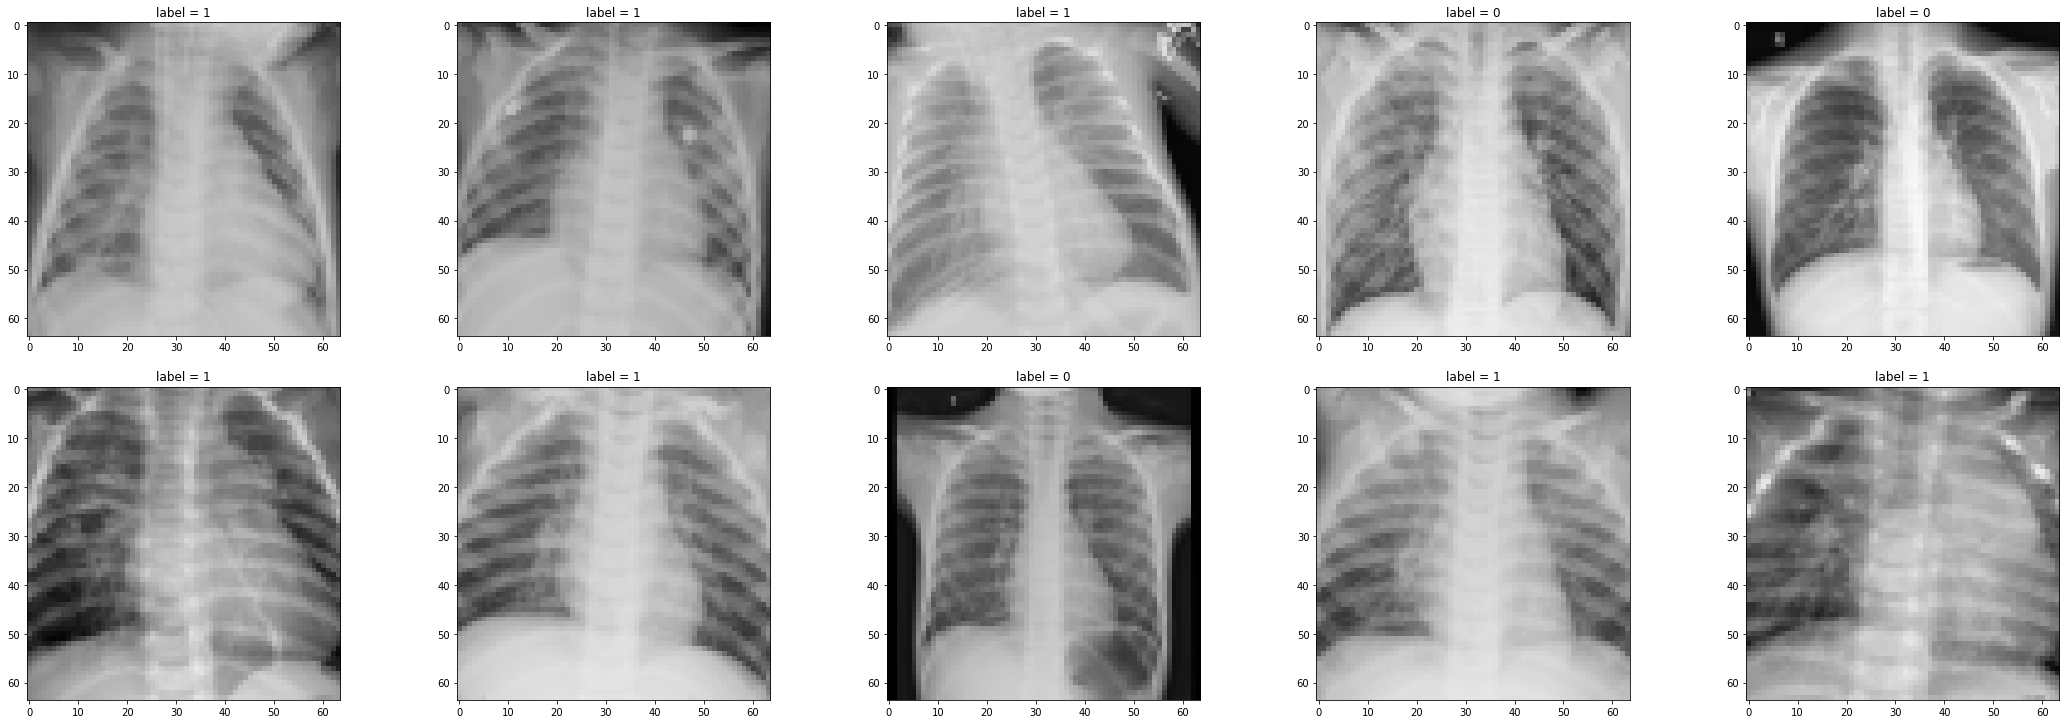

In [63]:
# Visualizing xrays
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30, 10))
ax = ax.ravel()
plt.tight_layout(h_pad=3)

for i in range(ax.shape[0]):
    ax[i].imshow(x_test[i], cmap='gray')
    ax[i].set_title('label = {}'.format(y_test[i]))

In [64]:
# Model parameters
ks33 = (3, 3)
ks22 = (2, 2)

In [65]:
# Design model with Keras Functional API 
inputs = Input(shape=(res, res, 3))

# Convolutional layer 1
conv1 = Conv2D(filters=16, kernel_size=ks33, activation='relu', padding='same')(inputs)
conv1 = Conv2D(filters=16, kernel_size=ks33, activation='relu', padding='same')(conv1)
conv1 = MaxPool2D(pool_size=(2, 2))(conv1)

# Convolutional layer 2
conv2 = Conv2D(filters=32, kernel_size=ks33, activation='relu', padding='same')(conv1)
conv2 = Conv2D(filters=32, kernel_size=ks33, activation='relu', padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = MaxPool2D(pool_size=(2, 2))(conv2)

# Convolutional layer 3
conv3 = Conv2D(filters=64, kernel_size=ks33, activation='relu', padding='same')(conv2)
conv3 = Conv2D(filters=64, kernel_size=ks33, activation='relu', padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = MaxPool2D(pool_size=(2, 2))(conv3)

# Fully-Connected layer
fc = Flatten()(conv3)
fc = Dense(units=256, activation='relu')(fc)
fc = Dropout(rate=0.5)(fc)
fc = Dense(units=64, activation='relu')(fc)
fc = Dropout(rate=0.2)(fc)

# Output
output = Dense(units=1, activation='sigmoid')(fc)

# Create model and compile
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [66]:
# Model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
__________

In [67]:
# Callbacks and image preprocessing

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
img_aug = ImageDataGenerator(rotation_range=20, vertical_flip=True, horizontal_flip=True)
img_aug.fit(x_train)

In [68]:
# Hyperparameters for fitting
batch_size = 74
epochs = 40
steps = x_train.shape[0] // batch_size

# Fitting model to data (val set too small, use test for validation)
model.fit_generator(img_aug.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=steps, epochs=epochs, 
                    validation_data=(x_test, y_test), callbacks=[reduce_lr], 
                    verbose=1)

Epoch 1/40
70/70 [==============================] - 64s 919ms/step - loss: 0.3255 - acc: 0.8743 - val_loss: 0.8991 - val_acc: 0.5817
Epoch 2/40
70/70 [==============================] - 57s 820ms/step - loss: 0.1920 - acc: 0.9312 - val_loss: 1.0452 - val_acc: 0.4167
Epoch 3/40
70/70 [==============================] - 57s 812ms/step - loss: 0.1725 - acc: 0.9324 - val_loss: 0.5347 - val_acc: 0.8205
Epoch 4/40
70/70 [==============================] - 57s 812ms/step - loss: 0.1570 - acc: 0.9427 - val_loss: 3.4855 - val_acc: 0.6298
Epoch 5/40
70/70 [==============================] - 57s 812ms/step - loss: 0.1496 - acc: 0.9413 - val_loss: 0.5201 - val_acc: 0.7580
Epoch 6/40
70/70 [==============================] - 57s 811ms/step - loss: 0.1356 - acc: 0.9453 - val_loss: 0.6550 - val_acc: 0.6571

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/40
70/70 [==============================] - 58s 824ms/step - loss: 0.1229 - acc: 0.9558 - val_loss: 0.4925 - val_

In [69]:
# Metrics

# Getting predictions
predictions = model.predict(x=x_test)

acc = accuracy_score(y_test, np.round(predictions))*100
tn, fp, fn, tp = confusion_matrix(y_test, np.round(predictions)).ravel()

print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(tp/(tp+fp)*100))
print('Recall: {}%'.format(tp/(tp+fn)*100))

Accuracy: 79.48717948717949%
Precision: 76.09561752988047%
Recall: 97.94871794871794%


In [70]:
print(confusion_matrix(y_test, np.round(predictions)).ravel())

[114 120   8 382]


NIH chest xray Dataset

In [7]:
img_path="data/xray_chest/images/"
img_height=64 #299
img_width=64 #299

#img_height=224 #299
#img_width=224 #299

PATH = os.path.abspath(os.path.join('..', 'data/xray_chest/images/'))
SOURCE_IMAGES = os.path.join(PATH, "sample", "images")


In [8]:
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))

images[0:10]

[]

In [9]:
labels = pd.read_csv('data/xray_chest/Data_Entry_2017.csv')
labels.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143,NaN


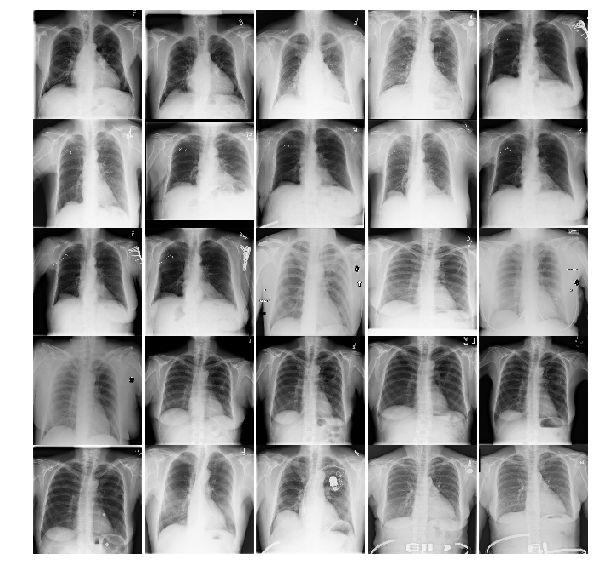

In [10]:
multipleImages = glob('data/xray_chest/images/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

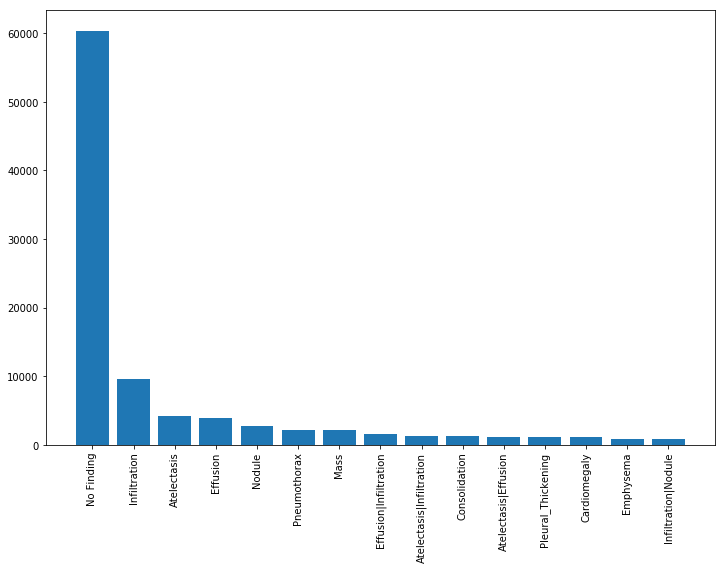

In [11]:
label_counts = labels ['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [16]:
labels['Finding Labels'] = labels['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*labels['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        labels[c_label] = labels['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
#print(labels(3))

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [18]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if labels[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(labels[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


In [19]:
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

def plot_img(img, title, count, cols, plot_axis=False):
    a = fig.add_subplot(1, cols, count)
    # if 'img' is a NumPy array, then it has already been loaded; just show it
    if type(img).__module__ == np.__name__:
        plt.imshow(img)
    else:
        plt.imshow(load_img(img))
    a.set_title(title,fontsize=10)
    if plot_axis is False:
        plt.axis('off')

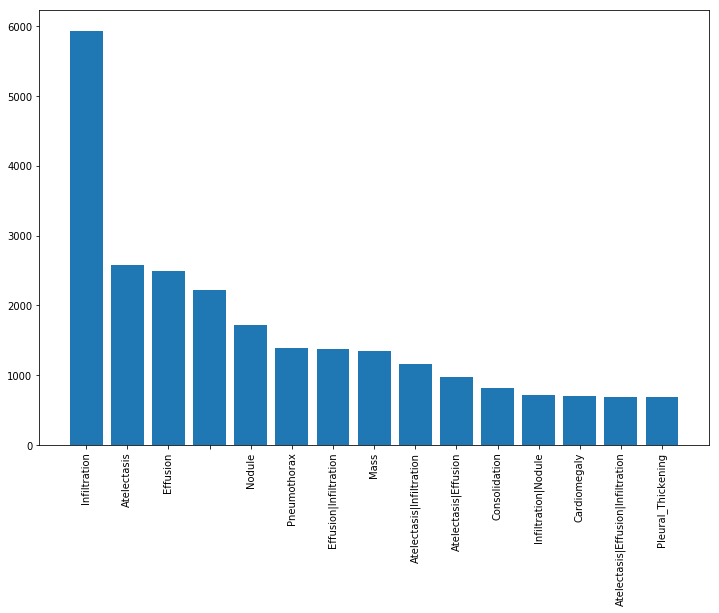

In [21]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = labels['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
labels = labels.sample(40000, weights=sample_weights)

label_counts = labels['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

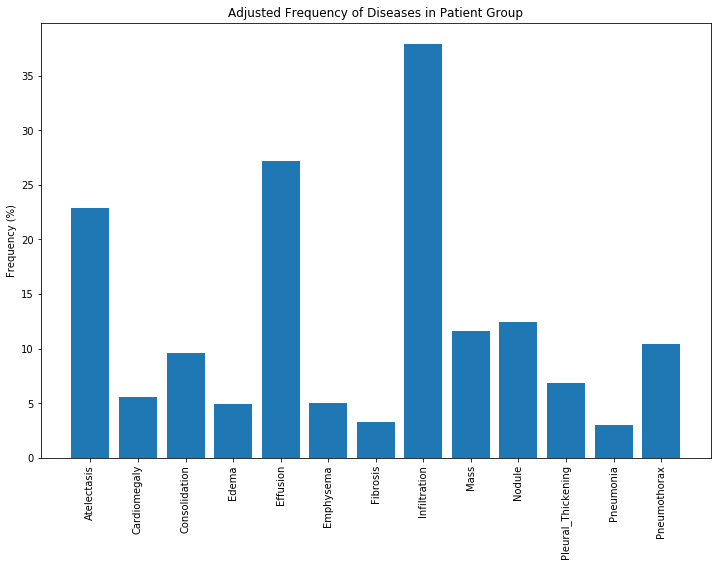

In [23]:
label_counts = 100*np.mean(labels[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

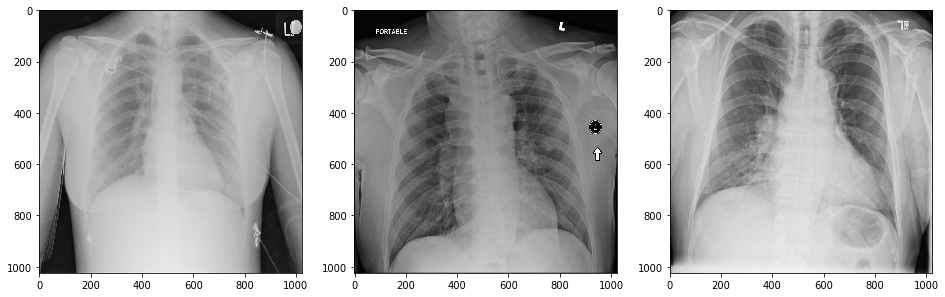

In [24]:
r = random.sample(multipleImages, 1000)
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(cv2.imread(r[0]))
plt.subplot(132)
plt.imshow(cv2.imread(r[1]))
plt.subplot(133)
plt.imshow(cv2.imread(r[2])); 

In [25]:
def create_label_directories(csv_filename, img_path, is_one_v_all=False, one_v_all_label="Pneumonia"):
    directories = set()
    with open(csv_filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(csvfile) # skip header row
        for row in reader:
            img_filename = str(row[0])
            labels = str(row[1])
            for label in labels.split('|'):
                if (is_one_v_all is True) and (label != one_v_all_label):
                    label = "ALL"
                src_file = os.path.join(img_path,img_filename)
                label = "_".join(label.split())
                dst_train_dir = os.path.join(img_path,"train",label)
                dst_train_file = os.path.join(dst_train_dir,img_filename)
                dst_valid_dir = os.path.join(img_path,"valid",label)
                dst_test_dir = os.path.join(img_path,"test",label)
                if not os.path.exists(dst_train_dir):
                    os.makedirs(dst_train_dir)
                    directories.add(label)
                if not os.path.exists(dst_valid_dir):
                    os.makedirs(dst_valid_dir)
                if not os.path.exists(dst_test_dir):
                    os.makedirs(dst_test_dir)
                src_file_abs = os.path.join(os.getcwd(),src_file)
                dst_train_file_abs = os.path.join(os.getcwd(),dst_train_file)
                #print("copy: " + src_file_abs + " to: " + dst_train_file_abs)
                if not os.path.exists(dst_train_file_abs):
                    os.symlink(src_file_abs, dst_train_file_abs)
    return list(directories)

is_one_v_all = True
one_v_all_label = "Pneumonia"
print(img_path)
directories = create_label_directories("data/xray_chest/Data_Entry_2017.csv", img_path, is_one_v_all, one_v_all_label)
print(directories)

data/xray_chest/images/
['Pneumonia', 'ALL']


In [26]:
def get_per_label_count(directories):
    per_label_count = []
    for ii in range(len(directories)):
        #print(directories[ii])
        path, dirs, files = os.walk(os.path.join(img_path,"train",directories[ii])).__next__()
        file_count = len(files)
        per_label_count.append(file_count)
    return per_label_count
        
print(directories)
per_label_count = get_per_label_count(directories) 
print(per_label_count)

['Pneumonia', 'ALL']
[1431, 111798]


In [27]:
def upsample(directories, per_label_count, iqr):
    for ii in range(len(per_label_count)):
        label = directories[ii]
        count = per_label_count[ii]
        if count < iqr:
            offset = iqr-count
#            subprocess.call(['./batch-augment.sh', os.path.join(os.getcwd(),img_path,"train",label), str(offset)])
    return get_per_label_count(directories)

print(directories)
print(per_label_count)
#print(label_batch_size)
per_label_count_upsampled = upsample(directories, per_label_count, 8430)#label_batch_size)
print(per_label_count_upsampled)

['Pneumonia', 'ALL']
[1431, 111798]
[1431, 111798]


In [43]:
def downsample(directories, per_label_count):
    label_idx = np.argmin(per_label_count)
    #print(label_idx)
    downsample_count = per_label_count[label_idx]
    #print(downsample_count)
    for ii in range(len(per_label_count)):
        label = directories[ii]
        src_train_dir = os.path.join(img_path,"train",label)
        all_img_paths = glob(os.path.join(src_train_dir,"*.*"))
        np.random.shuffle(all_img_paths)
        if len(all_img_paths) != downsample_count:
            imgs_to_remove = all_img_paths[downsample_count:]
            #print(len(imgs_to_remove))
            for file in imgs_to_remove:
                file_abs = os.path.join(os.getcwd(),file)
                #print("remove file: " + file_abs)
                os.remove(file_abs)
    return get_per_label_count(directories)
                


In [44]:
print(directories)
print(per_label_count_upsampled)
per_label_count_downsampled = downsample(directories, per_label_count_upsampled)
print(per_label_count_downsampled)

['Pneumonia', 'ALL']
[1431, 111798]
[1431, 1431]


In [46]:
def split_train_valid_test(directories, per_label_count, valid_pct, test_pct):
    for ii in range(len(directories)):
        all_img_paths = glob(os.path.join(img_path,"train",directories[ii],"*.*"))
        np.random.shuffle(all_img_paths)
        label_count = per_label_count[ii]
        valid_count = int(label_count*valid_pct)
        valid_files = all_img_paths[:valid_count]
        all_img_paths[:valid_count] = []
        test_count = int(label_count*test_pct)
        test_files = all_img_paths[:test_count]
        all_img_paths[:test_count] = []
        #print(len(valid_files))
        #print(len(test_files))
        train_files = all_img_paths
        all_img_paths = []
        #print(len(train_files))
        for valid_file in valid_files:
            valid_file_abs = os.path.join(os.getcwd(),valid_file)
            #print("move: '" + valid_file_abs + "' to: '" + os.path.join(img_path,"valid",directories[ii]))
            shutil.move(valid_file_abs, os.path.join(img_path,"valid",directories[ii]))
        for test_file in test_files:
            test_file_abs = os.path.join(os.getcwd(),test_file)
            #print("move: '" + test_file_abs + "' to: '" + os.path.join(img_path,"test",directories[ii]))
            shutil.move(test_file_abs, os.path.join(img_path,"test",directories[ii]))
        

valid_pct = 0.01 # 0.1
test_pct = 0.98 # 0.1       
print(directories)
print(per_label_count_downsampled)
split_train_valid_test(directories, per_label_count_downsampled, valid_pct, test_pct)

['Pneumonia', 'ALL']
[1431, 1431]


In [47]:
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True, 
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    'data/xray_chest/images/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')
    #color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
    'data/xray_chest/images/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size, #val_batch_size,
    class_mode='categorical')
    
test_generator = test_datagen.flow_from_directory(
    'data/xray_chest/images/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 30 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Found 2804 images belonging to 2 classes.


In [48]:
model = DenseNet121(include_top=True, weights=None, input_shape=(img_width,img_height,3), classes=2)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
_____________________________________

In [49]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True), metrics=['accuracy'])

In [50]:
filepath="weights.best.DenseNet121-nih-one-v-all-fibrosis.20180305-r1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min') #mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=500)
callbacks_list = [checkpoint,early_stopping]#,tensorboard]

Initial dataset code modified to work with NIH dataset.  Note:  ineffective.

In [51]:
# Final image resolution
res = 32
#res = 64

# Crop images to squares
def to_square(img):
    (h, w) = img.shape
    diff_half = np.abs(h-w) // 2
    
    if w > h:
        return(img[0:h, 0+diff_half:w-diff_half])
    elif w < h:
        return(img[0+diff_half:w-diff_half, 0:w])
    else: 
        return img

def load_data(dataset='train'):
    
    # Path where files are stored
    files_path = 'data/xray_chest/images/'+dataset
    
    #--- STEP 1: Create list containing names of image files ---#
    names_list = []
    for cat in ['/ALL', '/Pneumonia']:
        for img_name in os.listdir(files_path+cat):
            # Exclude non-image files
            if img_name[0] in ['I', 'N', 'p']:
                names_list.append(img_name)
    # Shuffle to feed into network
    random.Random(232).shuffle(names_list)
    
    #--- STEP 2: Create list of labels ---#
    labels = []
    for img_name in names_list:
        # 0 for normal, 1 for pneumonia
        if img_name[0] in ['I', 'N']:
            labels.append(0)
        elif img_name[0] == 'p':
            labels.append(1)
            
    #--- STEP 3: Load images and process them ---#
    img_list = []
    for img_name in tqdm(names_list):
        try:
            # Load images 
            if img_name[0] in ['I', 'N']:
                img = plt.imread(files_path+'/ALL/'+img_name)
            elif img_name[0] == 'p':
                img = plt.imread(files_path+'/Pneumonia/'+img_name)
                
            # Process images (normalize, square, reduce resolution)
            if len(img.shape) == 3:
                img = img[:,:,0]
            img = img / 255
            img = to_square(img)
            img = cv2.resize(img, dsize=(res, res), interpolation=cv2.INTER_AREA)
            img = img.reshape(res, res, 1)
            img = np.dstack([img, img, img])
            img_list.append(img)
        except OSError:
            pass
    
    return np.array(img_list), np.array(labels)

In [52]:
# Load data into each dataset pair
x_train, y_train = load_data(dataset='train')
x_val, y_val = load_data(dataset='valid')
x_test, y_test = load_data(dataset='test')

IndexError: index 0 is out of bounds for axis 0 with size 0

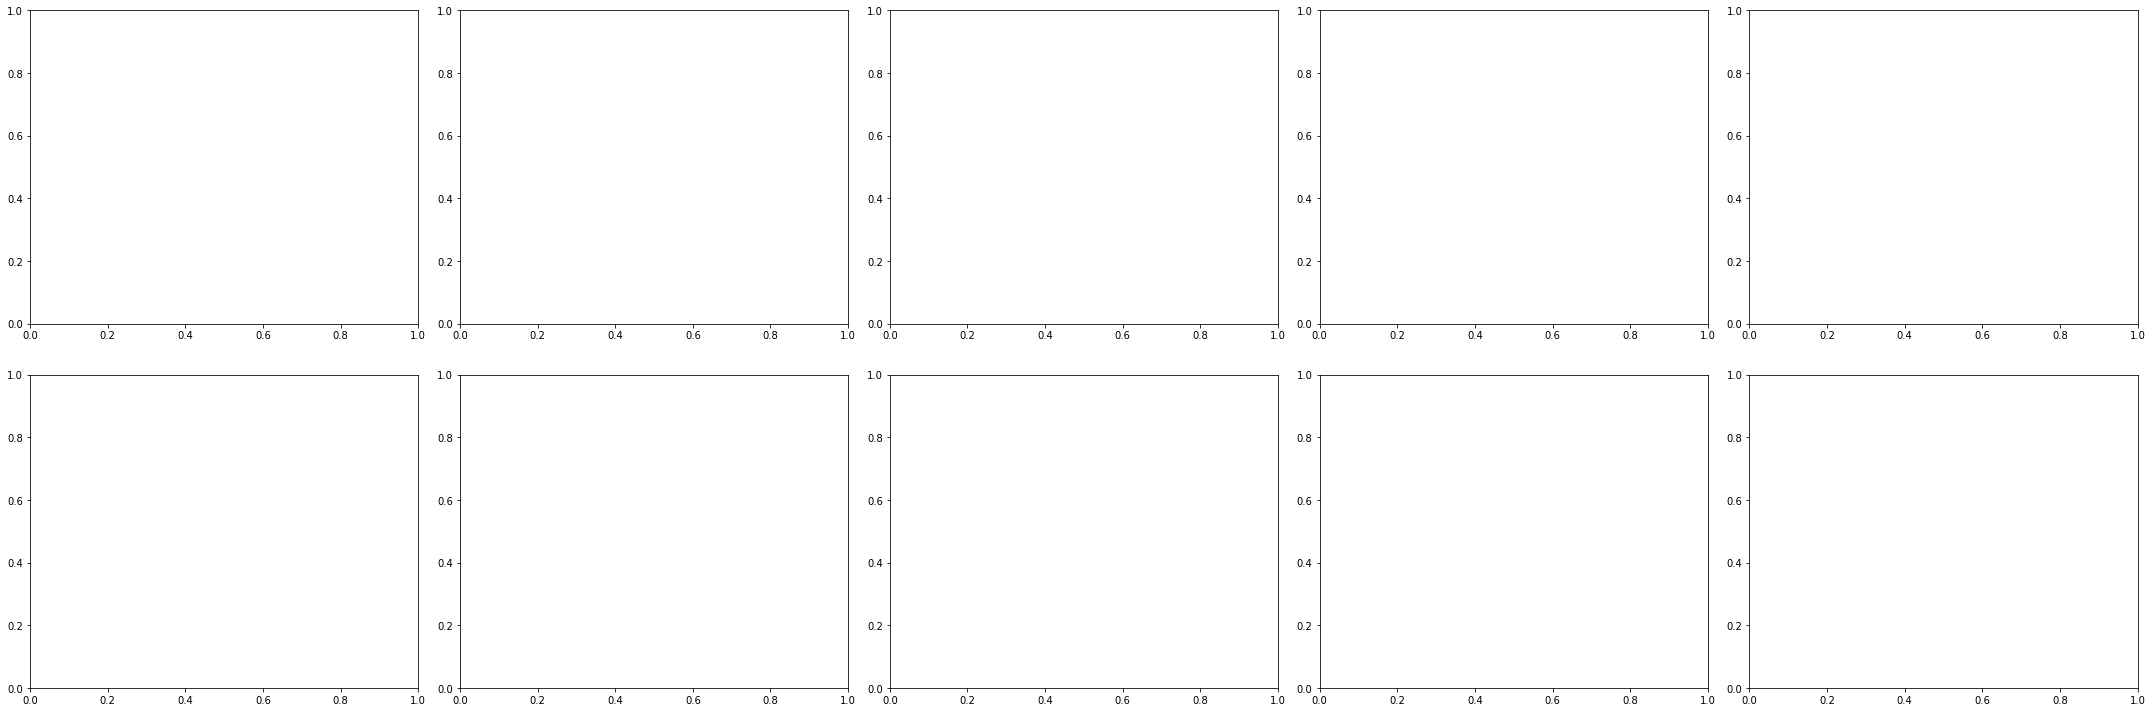

In [53]:
# Visualizing xrays
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30, 10))
ax = ax.ravel()
plt.tight_layout(h_pad=3)

for i in range(ax.shape[0]):
    ax[i].imshow(x_test[i], cmap='gray')
    ax[i].set_title('label = {}'.format(y_test[i]))

NIH Code

In [55]:
#nb_train_samples = 16188 #8094 #3036 #18046 #111589 #113243 #139987 
nb_train_samples = 88
nb_validation_samples= 336 
epochs = int(nb_train_samples/batch_size)*3
history = model.fit_generator(
    train_generator,
    steps_per_epoch=batch_size, #nb_train_samples/batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=batch_size, #nb_validation_samples/batch_size, #val_batch_size,
    callbacks=callbacks_list,
    verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/6
32/32 [==============================] - 130s 4s/step - loss: 1.3457 - acc: 0.8583 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 8.05905, saving model to weights.best.DenseNet121-nih-one-v-all-fibrosis.20180305-r1.hdf5
Epoch 2/6
32/32 [==============================] - 102s 3s/step - loss: 1.0746 - acc: 0.9333 - val_loss: 6.6625 - val_acc: 0.5000

Epoch 00002: val_loss improved from 8.05905 to 6.66254, saving model to weights.best.DenseNet121-nih-one-v-all-fibrosis.20180305-r1.hdf5
Epoch 3/6
32/32 [==============================] - 102s 3s/step - loss: 1.0746 - acc: 0.9333 - val_loss: 5.3783 - val_acc: 0.3571

Epoch 00003: val_loss improved from 6.66254 to 5.37828, saving model to weights.best.DenseNet121-nih-one-v-all-fibrosis.20180305-r1.hdf5
Epoch 4/6
32/32 [==============================] - 101s 3s/step - loss: 1.0746 - acc: 0.9333 - val_loss: 5.9777 - val_acc: 0.4643

Epoch 00004: val_loss

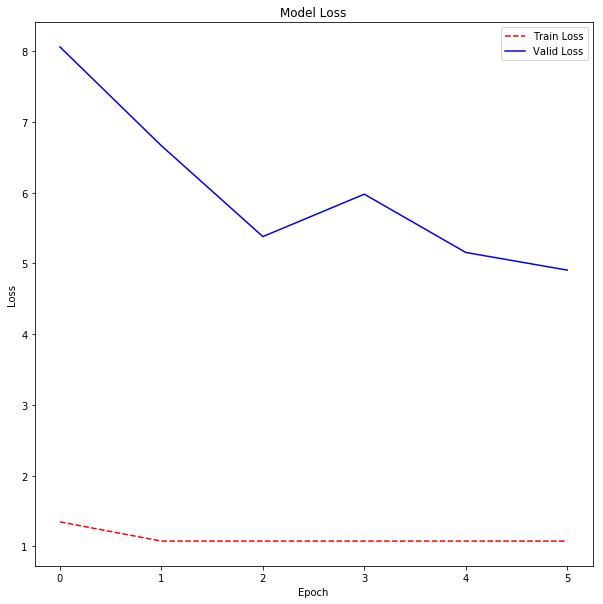

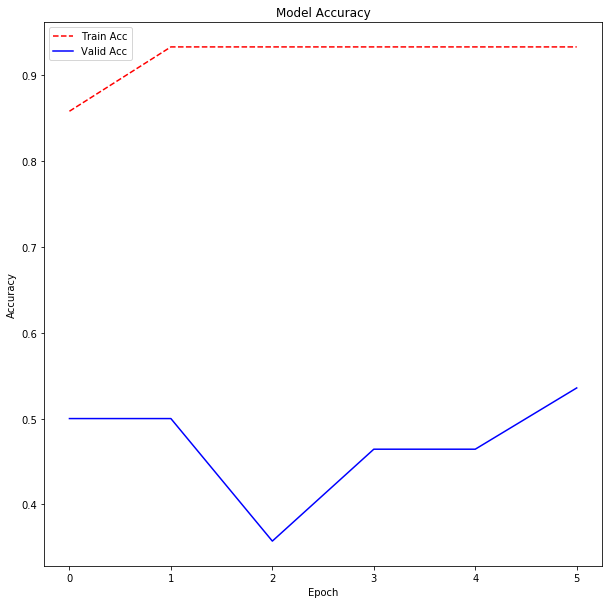

In [56]:
def plot_history(history):
    plt.plot(history.history['loss'],'r--')
    plt.plot(history.history['val_loss'],'b-')
    plt.title('Model Loss')
    plt.legend(['Train Loss', 'Valid Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();
    plt.plot(history.history['acc'],'r--')
    plt.plot(history.history['val_acc'],'b-')
    plt.title('Model Accuracy')
    plt.legend(['Train Acc', 'Valid Acc'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

# requires history=model.fit, fit_generator...
plot_history(history)

In [57]:
scores = model.evaluate_generator(test_generator, steps=10, max_queue_size=10, workers=1, use_multiprocessing=False)
print("score = Loss: %f, Acc@1: %.2f" % (scores[0],scores[1]))

score = Loss: 4.978679, Acc@1: 0.48


In [58]:
preds = model.predict_generator(test_generator, steps=10, max_queue_size=10, workers=1, use_multiprocessing=False)
preds.shape

(320, 2)

In [59]:
#print(test_generator.classes)
steps = 11 #int(SIZE?/batch_size)
preds = np.zeros((0,2))
y_test = np.zeros((0,2))
step_count = 0
for batch_x, batch_y in test_generator:
    if step_count < steps:
        batch_preds = model.predict(batch_x)
        #print(batch_preds.shape)
        preds = np.vstack((preds,batch_preds))
        #print(batch_y)
        y_test = np.vstack((y_test,batch_y))
        step_count = step_count + 1
    else:
        break
        
print(preds.shape)
print(y_test.shape)

(352, 2)
(352, 2)


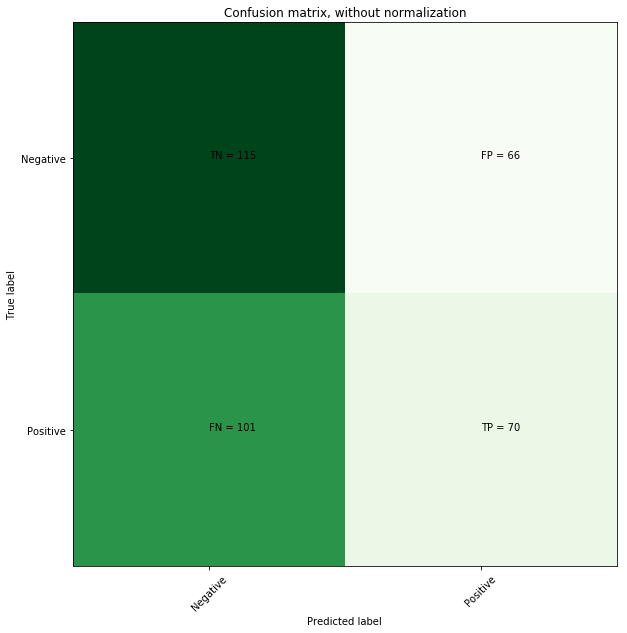

In [60]:
y_trues = [np.argmax(ii) for ii in y_test]
y_preds = [np.argmax(ii) for ii in preds]

# credit: https://tatwan.github.io/How-To-Plot-A-Confusion-Matrix-In-Python/    
def plot_binary_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    classNames = classes
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    
cm = confusion_matrix(y_trues, y_preds)
#print(cm)
tn, fp, fn, tp = cm.ravel()
#print(tn, fp, fn, tp)

# Plot non-normalized confusion matrix
plt.figure()
plot_binary_confusion_matrix(cm, classes=['Negative','Positive'], title='Confusion matrix, without normalization', cmap=plt.cm.Greens)
plt.show()